In [1]:
import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Fungsi untuk preprocess gambar
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize ke 128x128
    return image / 255.0  # Normalisasi (0-1)

# Fungsi untuk ekstraksi fitur HOG
def extract_hog_features(images):
    hog_features = [hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False) for img in images]
    return np.array(hog_features)


In [3]:
# Membaca dataset
data = []
labels = []
classes = os.listdir("dataset")

for idx, class_name in enumerate(classes):
    class_path = os.path.join("dataset", class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = preprocess_image(img_path)
        data.append(img)
        labels.append(idx)

data = np.array(data)
labels = np.array(labels)

In [4]:
# Split data menjadi training dan validation
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


In [5]:
# Ekstraksi fitur HOG
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)

In [6]:
# Pengurangan dimensi dengan PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_hog)
X_val_pca = pca.transform(X_val_hog)

In [7]:
# Tuning parameter Random Forest
def tune_random_forest(X, y):
    param_grid = {
        'n_estimators': [50, 100, 150],  # Jumlah pohon
        'max_depth': [10, 20, 30],       # Kedalaman maksimum
        'min_samples_split': [2, 5, 10]  # Minimal sampel untuk split
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

In [8]:
# Melatih model Random Forest dengan parameter terbaik
model = tune_random_forest(X_train_pca, y_train)
model.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=42)

In [9]:
# Evaluasi model
y_pred = model.predict(X_val_pca)
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       0.75      1.00      0.86         3
          10       0.75      1.00      0.86         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      0.75      0.86         4

    accuracy                           0.95        42
   macro avg       0.96      0.96      0.96        42
weighted avg       0.96      0.95      0.95        

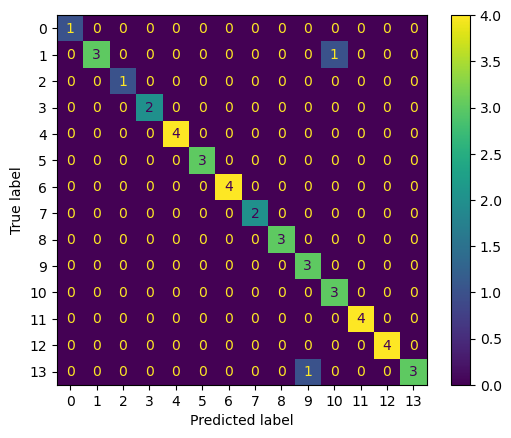

In [10]:

# Menampilkan Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_val_pca, y_val)
plt.show()
